In [10]:
import pandas as pd
import torch
from sklearn.metrics.pairwise import cosine_similarity
from transformers import BertTokenizer, BertModel
import joblib
import networkx as nx
import matplotlib.pyplot as plt

In [4]:
path_to_kg_df = "DataFrame.pkl"
kg_df = joblib.load(path_to_kg_df)

print(kg_df.head())

         source                                             target     edge
0          that  unauthorized computer infrastructure   confide...   occurs
1          that  interconnected computer systems most in domain...       is
2        system                                     secure  system      are
3  Perpetrators                                     of cyberattack   can be
4          They  weaknesses  in system   them   malware   goals...  attempt


In [5]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

In [6]:
def get_entity_embeddings(entities):
    entity_embeddings = {}
    for entity in entities:
        inputs = tokenizer(entity, return_tensors='pt')
        outputs = model(**inputs)
        embeddings = outputs.last_hidden_state.mean(dim=1)
        entity_embeddings[entity] = embeddings.detach().numpy()
    return entity_embeddings

unique_entities = set(kg_df['source']).union(set(kg_df['target']))
entity_embeddings = get_entity_embeddings(unique_entities)


In [7]:
def merge_similar_entities(entities, embeddings, threshold=0.8):
    merged_entities = {}
    for entity1 in entities:
        merged_entities[entity1] = entity1
        for entity2 in entities:
            if entity1 != entity2:
                sim = cosine_similarity(embeddings[entity1], embeddings[entity2])[0][0]
                if sim >= threshold:
                    merged_entities[entity2] = entity1
    return merged_entities

In [9]:
merged_entities = merge_similar_entities(unique_entities, entity_embeddings)
kg_df['source'] = kg_df['source'].map(merged_entities)
kg_df['target'] = kg_df['target'].map(merged_entities)

reduced_kg_df = kg_df.drop_duplicates(subset=['source', 'edge', 'target'])

joblib.dump(reduced_kg_df, "reduced_knowledge_graph.pkl")
print("Reduced knowledge graph has been saved as 'reduced_knowledge_graph.pkl'")

Reduced knowledge graph has been saved as 'reduced_knowledge_graph.pkl'


In [11]:
path_to_reduced_kg = "reduced_knowledge_graph.pkl"
kg_df = joblib.load(path_to_reduced_kg)

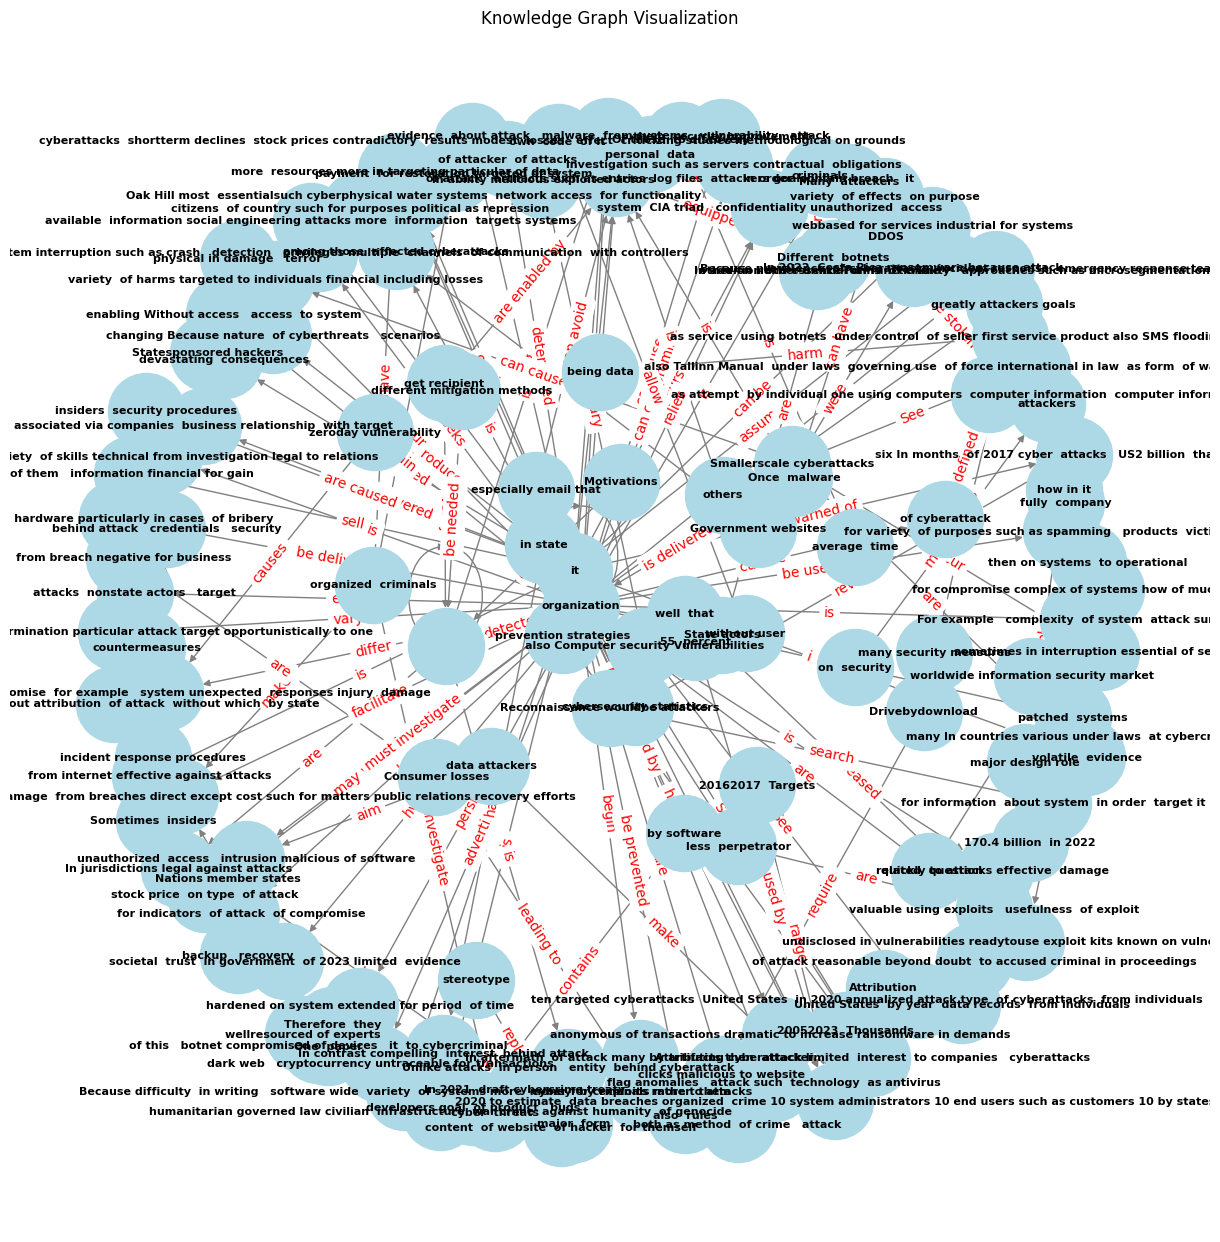

In [12]:
G = nx.DiGraph()

for _, row in kg_df.iterrows():
    source = row['source']
    target = row['target']
    edge = row['edge']
    G.add_edge(source, target, label=edge)

plt.figure(figsize=(12, 12))
pos = nx.spring_layout(G, k=0.5)
nx.draw(G, pos, with_labels=True, node_size=3000, node_color='lightblue', font_size=8, font_weight='bold', edge_color='gray')
edge_labels = nx.get_edge_attributes(G, 'label')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='red')

plt.title("Knowledge Graph Visualization")
plt.show()

In [13]:
import pandas as pd
import joblib
import networkx as nx

raw_kg_path = "DataFrame.pkl"
reduced_kg_path = "reduced_knowledge_graph.pkl"
raw_kg_df = joblib.load(raw_kg_path)
reduced_kg_df = joblib.load(reduced_kg_path)

raw_G = nx.from_pandas_edgelist(raw_kg_df, 'source', 'target', edge_attr='edge', create_using=nx.DiGraph())
reduced_G = nx.from_pandas_edgelist(reduced_kg_df, 'source', 'target', edge_attr='edge', create_using=nx.DiGraph())

raw_node_count = raw_G.number_of_nodes()
raw_edge_count = raw_G.number_of_edges()
reduced_node_count = reduced_G.number_of_nodes()
reduced_edge_count = reduced_G.number_of_edges()

print("Comparison of Knowledge Graphs:")
print(f"Raw Knowledge Graph - Nodes: {raw_node_count}, Edges: {raw_edge_count}")
print(f"Reduced Knowledge Graph - Nodes: {reduced_node_count}, Edges: {reduced_edge_count}")
print("Reduction Summary:")
print(f"Node Reduction: {raw_node_count - reduced_node_count} ({(raw_node_count - reduced_node_count) / raw_node_count * 100:.2f}%)")
print(f"Edge Reduction: {raw_edge_count - reduced_edge_count} ({(raw_edge_count - reduced_edge_count) / raw_edge_count * 100:.2f}%)")


Comparison of Knowledge Graphs:
Raw Knowledge Graph - Nodes: 259, Edges: 149
Reduced Knowledge Graph - Nodes: 145, Edges: 135
Reduction Summary:
Node Reduction: 114 (44.02%)
Edge Reduction: 14 (9.40%)
